<a href="https://colab.research.google.com/github/alina-bogdanovskaya/Data-Analysis_May2022/blob/lesson5/Data_Analysis_lesson5_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [200]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from matplotlib.colors import ListedColormap
from sklearn import datasets
from collections import Counter
import numpy as np
from sklearn import model_selection

In [201]:
class Node:
  def __init__(self, index, t, true_branch, false_branch):
    self.index = index
    self.t = t 
    self.true_branch = true_branch 
    self.false_branch = false_branch 

  def __str__(self):
    return f'Индекс: {self.index},\\n порог: {self.t}'

  def __repr__(self):
    return f'Индекс: {self.index},\\n порог: {self.t}'
        
class Leaf:
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
    self.classes = Counter(self.labels)
    self.prediction = self.predict()
    self.prob_class1 = self.classes[1]/len(self.labels)
        
  def predict(self):
    prediction = self.classes.most_common()[0][0]
    return prediction

  def __str__(self):
    return f'Класс: {self.predict()}, \\n объектов класса 0: {self.classes[0]}, \\n объектов класса 1: {self.classes[1]}'

  def __repr__(self):
    return f'Класс: {self.predict()}, \\n объектов класса 0: {self.classes[0]}, \\n объектов класса 1: {self.classes[1]}'  


In [202]:
def gini(labels):
  classes = {}
  for label in labels:
    if label not in classes:
      classes[label] = 0
    classes[label] += 1

  impurity = 1
  for label in classes:
    p = classes[label] / len(labels)
    impurity -= p ** 2
        
  return impurity


def quality(left_labels, right_labels, current_gini):
  p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
  return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)


def split(data, labels, index, t):
  left = np.where(data[:, index] <= t)
  right = np.where(data[:, index] > t)
  true_data = data[left]
  false_data = data[right]
  true_labels = labels[left]
  false_labels = labels[right]
  return true_data, false_data, true_labels, false_labels


def get_subsample(len_sample):
  sample_indexes = [i for i in range(len_sample)]
  len_subsample = int(np.sqrt(len_sample))
  subsample = []
  random.shuffle(sample_indexes)
  for _ in range(len_subsample):
    subsample.append(sample_indexes.pop())
  return subsample


def find_best_split(data, labels):
  min_leaf = 1
  current_gini = gini(labels)
  best_quality = 0
  best_t = None
  best_index = None
  n_features = data.shape[1]
    
  subsample = get_subsample(n_features)
  for index in subsample:
    t_values = np.unique([row[index] for row in data])
        
    for t in t_values:
      true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
      if len(true_data) < min_leaf or len(false_data) < min_leaf:
        continue
            
      current_quality = quality(true_labels, false_labels, current_gini)
      if current_quality > best_quality:
        best_quality, best_t, best_index = current_quality, t, index

  return best_quality, best_t, best_index


def build_tree(data, labels):
  quality, t, index = find_best_split(data, labels)

  if quality == 0:
    return Leaf(data, labels)

  true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
  true_branch = build_tree(true_data, true_labels)
  false_branch = build_tree(false_data, false_labels)

  return Node(index, t, true_branch, false_branch)


def classify_object(obj, node):
  if isinstance(node, Leaf):
    answer = node.prediction
    return answer

  if obj[node.index] <= node.t:
    return classify_object(obj, node.true_branch)
  else:
    return classify_object(obj, node.false_branch)
    
    
def predict(data, tree):
  classes = []
  for obj in data:
    prediction = classify_object(obj, tree)
    classes.append(prediction)
  return np.array(classes)

In [203]:
random.seed(48)

def get_bootstrap(data, labels, N):
  n_samples = data.shape[0]
  bootstrap = []
  for i in range(N):
    indexes = np.random.randint(0, n_samples-1, size=labels.shape)
    mask = np.ones((data.shape[0],), dtype=bool)
    mask[indexes] = False
    bootstrap.append((data[indexes, :], labels[indexes], mask))
  return bootstrap


def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels, mask in bootstrap:
        cur_tree = build_tree(b_data, b_labels) 
        forest.append(cur_tree)
        cur_tree.score = 1
        
    return forest, bootstrap


def tree_vote(forest, data):
  predictions = []
  for tree in forest:
    predictions.append(predict(data, tree))
        
  n_objects = data.shape[0]
  n_classes = max([max(p) for p in predictions])+1
  scores = np.zeros((n_objects, n_classes))
  
  for tree, p in zip(forest, predictions):
    scores[np.arange(n_objects), p]+=tree.score
  
  return np.apply_along_axis(np.argmax, 1, scores)

In [204]:
def accuracy_metric(actual, predicted):
  return np.sum(actual==predicted)/len(actual)

def balanced_accuracy_metric(actual, predicted):
  true_predicted = (actual==predicted).astype(int)
  sensitivity = np.sum(actual * true_predicted)/np.sum(actual==1)
  specificity = np.sum((1 - actual) * true_predicted)/np.sum(actual==0)
  return 0.5 * (sensitivity + specificity)

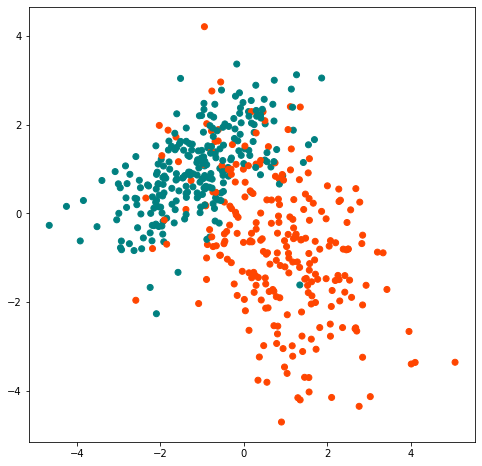

In [205]:
clas_data, clas_labels = datasets.make_classification(n_samples=500, n_features=5,
                                                      n_informative=5, n_classes=2,
                                                      n_redundant=0, n_clusters_per_class=1,  
                                                      random_state=23)

colors = ListedColormap(['orangered', 'teal'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], clas_data)), list(map(lambda x: x[1], clas_data)), 
              c=clas_labels, cmap=colors)

In [235]:
n_trees = 3
my_forest_3, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [236]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_3, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 3 деревьев составлет  98.60%, сбалансированная точность составляет  98.60%


In [237]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_3, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  # print(tree.score)

forest_answers = tree_vote(my_forest_3, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

Точность леса из 3 деревьев составлет  98.60%, сбалансированная точность составляет  98.60%


In [232]:
n_trees = 10
my_forest_10, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [233]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_10, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 10 деревьев составлет  99.20%, сбалансированная точность составляет  99.20%


In [234]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_10, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  # print(tree.score)

forest_answers = tree_vote(my_forest_10, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

Точность леса из 10 деревьев составлет  99.60%, сбалансированная точность составляет  99.60%


In [241]:
n_trees = 17
my_forest_17, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [242]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_17, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 17 деревьев составлет  100.00%, сбалансированная точность составляет  100.00%


In [243]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_17, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  # print(tree.score)

forest_answers = tree_vote(my_forest_17, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

Точность леса из 17 деревьев составлет  100.00%, сбалансированная точность составляет  100.00%


Попробуем рассчитать точность деревьев на более сложных данных

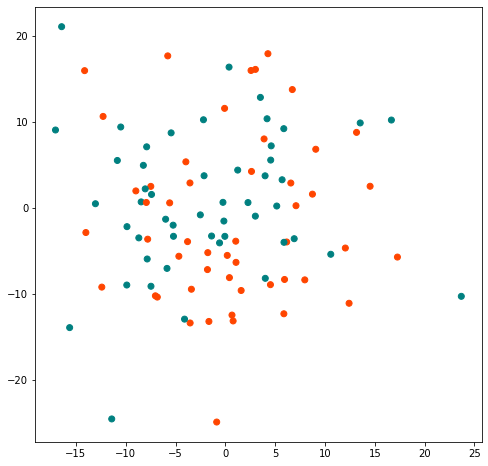

In [246]:
clas_data, clas_labels = datasets.make_classification(n_samples=100, n_features=200,
                                                      n_informative=200, n_classes=2,
                                                      n_redundant=0, n_clusters_per_class=7,  
                                                      class_sep=0.02, random_state=2)

colors = ListedColormap(['orangered', 'teal'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], clas_data)), list(map(lambda x: x[1], clas_data)), 
              c=clas_labels, cmap=colors)

In [247]:
n_trees = 3
my_forest_3, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [248]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_3, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 3 деревьев составлет  93.00%, сбалансированная точность составляет  93.00%


In [250]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_3, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  # print(tree.score)

forest_answers = tree_vote(my_forest_3, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

Точность леса из 3 деревьев составлет  93.00%, сбалансированная точность составляет  93.00%


In [253]:
n_trees = 10
my_forest_10, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [254]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_10, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 10 деревьев составлет  97.00%, сбалансированная точность составляет  97.00%


In [255]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_10, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  # print(tree.score)

forest_answers = tree_vote(my_forest_10, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

Точность леса из 10 деревьев составлет  96.00%, сбалансированная точность составляет  96.00%


In [256]:
n_trees = 17
my_forest_17, my_bootstraps = random_forest(clas_data, clas_labels, n_trees)

In [257]:
# Рассчитаем точность и сбалансированную точность при одинаковом весе каждого дерева (по умолчанию tree.score = 1)
forest_answers = tree_vote(my_forest_17, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')

Точность леса из 17 деревьев составлет  99.00%, сбалансированная точность составляет  99.00%


In [259]:
# Рассчитаем OOB-score для каждого дерева и примем этот показатель в качестве веса дерева при голосовании
for tree, bootstrap in zip(my_forest_17, my_bootstraps):
  oob_answers = predict(clas_data[bootstrap[2]], tree)
  tree.score = accuracy_metric(clas_labels[bootstrap[2]], oob_answers)
  print(tree.score)

forest_answers = tree_vote(my_forest_17, clas_data)
forest_acc = accuracy_metric(clas_labels, forest_answers)
forest_balanced_acc = balanced_accuracy_metric(clas_labels, forest_answers)
print(f'Точность леса из {n_trees} деревьев составлет {forest_acc*100: .2f}%, сбалансированная точность составляет {forest_balanced_acc*100: .2f}%')
  

0.5128205128205128
0.6470588235294118
0.375
0.5263157894736842
0.5
0.4411764705882353
0.5263157894736842
0.5294117647058824
0.42857142857142855
0.7142857142857143
0.4375
0.6486486486486487
0.4838709677419355
0.5263157894736842
0.5789473684210527
0.45
0.53125
Точность леса из 17 деревьев составлет  99.00%, сбалансированная точность составляет  99.00%


Как видим, случайный лес - достаточно точный метод классификации, и использование OOB-score в качестве веса дерева при голосовании не оказывает заметного влияния на показтели точности и сбалансированной точности леса в целом, несмотря на то, что на сложных данных точность каждого отдельного дерева довольно низкая.

In [176]:
def OOB(data, labels, n_trees, forest, bootstrap):
  oob = 0

  for i in range(len(labels)):
    trees_not_trained = 0
    predictions_sum = 0

    for n in range(n_trees):
      tree = forest[n]
      tree_train_data = bootstrap[n][0]
      # print(clas_data[i]) 
      # print(tree_train_data)
      

      if data[i] in tree_train_data:
        continue

      trees_not_trained += 1
      predictions_sum += predict([data[i]], tree)

    if trees_not_trained == 0:
      continue
      
    y_predicted = predictions_sum/trees_not_trained
    oob += (labels[i] - y_predicted)**2

  return oob/len(data)